In [ ]:
#Dependencies
import torch 
import torch.nn.functional as F
from torch import nn,optim
from torchvision import transforms as tf

import learn2learn as l2l
from learn2learn.data import MetaDataset, TaskDataset
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels
'''In learn2learn==0.2.0, sometimes the .utils package won't be exported properly, even though it exists in the root folder(atleast in my case). This
   was resolved by editing the __init__.py on the main folder, and editing the "from utils import *" =>"from . import utils" and restarting the kernel'''
import learn2learn.utils        

import matplotlib.pyplot as plt
from IPython.display import clear_output

import gc
import random


e:\DL\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
(CVXPY) Jun 23 08:32:30 AM: Encountered unexpected exception importing solver CLARABEL:
ImportError('DLL load failed while importing clarabel: The specified procedure could not be found.')


In [ ]:
#Backbone CNN
'''This 3-block custom CNN is used as the backbone for my protoNET. Takes in 32x32 res input and produces as 
    1024b 1D embedding tensor. Youcan play with adding additional conv layers to increase learnt features, or anything
    else'''

class BackBone_CNN(nn.Module):
    def __init__(self,output_size):
        super(BackBone_CNN,self).__init__()
        def conv_block(in_channels,out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
                nn.BatchNorm2d(out_channels),           
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.MaxPool2d(kernel_size=2)
            )
        self.encoder=nn.Sequential( 
            conv_block(3,64),       #32x32 => 16x16
            conv_block(64,64),      #16x16 => 8x8
            conv_block(64,64),      #8*8 => 4*4
        )
        self.classifier=nn.Linear(64*4*4,output_size)
    def forward(self,x):
        x=self.encoder(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [ ]:
#Data Division and Sampler
'''This is a helper class designed to return one sampled task containing {support,query} datasets and labels, while
    also transoforming the data and indexing in O(1) [look about MetaDataSet for more info]. Do change the folder 
    directory.'''

class EpisodeSampler:
    def __init__(self,train_ways,train_samples,test_samples):
        self.train_ways=train_ways
        self.train_samples=train_samples
        self.test_samples=test_samples
        self.k=train_samples+test_samples  

        self._train_episode=None
        self._val_episode=None
        self._test_episode=None


    def build_episode(self,mode):        
        transforms=tf.Compose([
            tf.Resize((32, 32)),
            tf.RandomHorizontalFlip(),
            tf.ColorJitter(brightness=0.2, contrast=0.2),
            tf.RandomCrop(32, padding=4),
            tf.ToTensor()
        ])

        #Dataset        
        data=l2l.vision.datasets.CIFARFS(
            root='E:/DL/data',
            download=True,
            mode=mode,
            transform=transforms)

        sampling_ds=MetaDataset(data)
        return TaskDataset(
            sampling_ds,
            task_transforms=[
                NWays(sampling_ds,n=self.train_ways),
                KShots(sampling_ds,k=self.k),
                LoadData(sampling_ds),
                RemapLabels(sampling_ds)
            ],num_tasks=1000                   #generates 1000's of precompiled tasks, out of which one random will be selected and returned
        )
    
    
    #defined as properties, to dynamically compute required episodes, thus avoiding precompiled data space
    @property
    def train_episode(self):
        if self._train_episode is None:
            self._train_episode=self.build_episode('train')
        return self._train_episode
    @property
    def val_episode(self):
        if self._val_episode is None:
            self._val_episode=self.build_episode('validation')
        return self._val_episode
    @property
    def test_episode(self):
        if self._test_episode is None:
            self._test_episode=self.build_episode('test')
        return self._test_episode
    

    #splits (data,query) into (support_data,support_label,query_data,query_label)
    def SQ_split(self,data,labels):
        #splitting index
        num_support=self.train_ways*self.train_samples
        num_query=self.train_ways*self.test_samples

        #support split
        support_data=data[:num_support]
        support_labels=labels[:num_support]

        #query split
        query_data=data[num_support:num_support+num_query]
        query_labels=labels[num_support:num_support+num_query]

        return support_data,support_labels,query_data,query_labels  

    def sample_train_episode(self):
        index = random.randint(0, len(self.train_episode) - 1)
        data, labels = self.train_episode[index]
        return self.SQ_split(data, labels)                     #Returns 1 random training episode containing support and query seperately 
    def sample_validation_episode(self):
        index = random.randint(0, len(self.val_episode) - 1)
        data, labels = self.val_episode[index]
        return self.SQ_split(data, labels)                     #Returns 1 random validation episode containing support and query seperately 
    def sample_test_episode(self):
        index = random.randint(0, len(self.test_episode) - 1)
        data, labels = self.test_episode[index]
        return self.SQ_split(data, labels)                     #Returns 1 random testing episode containing support and query seperately 

In [ ]:
class MetaIO_params:
    '''This function takes in {support:embeddings,labels ; query:embeddings,labels} as input, processes
        it, and returns the loss. 'n' such losses are calculated, summed and then optimized as a
        bunch, which forms a task. This entire fn is an episodic, stateless function '''
    
    def __init__(self,support_embeddings,support_labels,query_embeddings,query_labels):
        self.support_embeddings=support_embeddings
        self.support_labels=support_labels
        self.query_embeddings=query_embeddings
        self.query_labels=query_labels

    #1. Mean Embeddings
    def Ck(support_embeddings,support_labels):
        classes=torch.unique(support_labels)
        mean_embed=[] 
        for c in classes:
            mask= support_labels==c                 #boolean tensor which is true for values with matching class numbers
            embed=support_embeddings[mask]          #Filtered values according to the bool tensor
            prototype=embed.mean(dim=0)             
            mean_embed.append(prototype)
        return torch.stack(mean_embed)              #returns a tensor containing mean dimensions for each classes, like for class 1-3, the o/p looks like [[1,0.5,3],[4,2,1],[0.6,9,4]]
    
    #2. Loss+predictive probablity:
    def lossFn(ck_embed, query_embeddings,query_labels,support_labels):
        dist=torch.cdist(query_embeddings,ck_embed,p=2)        #calculates euclidean dist (Cosine sim not used as it isn't a Bergman dist)
        p_phi=F.log_softmax(-dist,dim=1)                       #Softmaxx over negatives

        # Map query labels to index positions of unique support labels. This is done to avoid confusing the loss fn, as mismatch in labels results in bogus values
        unique_classes=torch.unique(support_labels)
        label_map={label.item(): idx for idx,label in enumerate(unique_classes)}
        mapped_labels=torch.tensor(
            [label_map[label.item()] for label in query_labels if label.item() in label_map],
            dtype=torch.long,device=query_labels.device
        )

        # Filter query embeddings and logits to match mapped labels
        valid_indices=[i for i,label in enumerate(query_labels) if label.item() in label_map]
        query_embeddings=query_embeddings[valid_indices]
        p_phi=p_phi[valid_indices]

        ce_loss = F.nll_loss(p_phi,mapped_labels)
        prediction=torch.argmax(p_phi,dim=1)
        accuracy=(prediction==mapped_labels).float().mean()
        return ce_loss,accuracy
    

    #3. the return function for loss and accuracy: -
    def get_params(self):
        prototype=MetaIO_params.Ck(self.support_embeddings,self.support_labels)
        ce_loss,accuracy=MetaIO_params.lossFn(prototype,self.query_embeddings,self.query_labels,self.support_labels)
        return ce_loss,accuracy

In [ ]:
#Tuning parameters:
'''This is just a class used for looking and editing at all the various parameters used throught the code'''

class TuningParameters():
    #data params
    _train_ways=6
    _train_samples=5
    _test_samples=15
    
    #meta params
    _epoch=200                      #how many times the collective losses are summed and updated
    _tasks_per_epoch=80             #how many distinct losses are calculated  [if using higher RAM, please increase it]

    #misc params
    _output_size=64                 #CNN output size


    @property
    def train_ways(self):
        return self._train_ways
    @property
    def train_samples(self):
        return self._train_samples
    @property
    def test_samples(self):
        return self._test_samples
    @property
    def epoch(self):
        return self._epoch
    @property
    def tasks_per_epoch(self):
        return self._tasks_per_epoch
    @property
    def output_size(self):
        return self._output_size
    @property
    def device(self):
        return self._device

In [ ]:
#Model performance validation fn
'''This fn is used mainly to test the protoNET in an unseen dataset. Uses testing episodes, which are not in the
    original training episodes, to better gauge the performance of the NN as a whole.'''
    
def evaluate_on_test_set(model,episode_sampler,tuning_params,device=torch.device('cuda'),num_tasks=100):
    model.eval()
    total_loss=0.0
    total_accuracy=0.0

    with torch.no_grad():               #prevents updation of CNN params
        for i in range(num_tasks):
            
            #data is split and shifted to device
            sdata,slabels,qdata,qlabels=episode_sampler.sample_test_episode()
            support_data=sdata.to(device)
            query_data=qdata.to(device)
            support_labels=slabels.to(device)
            query_labels=qlabels.to(device)

            #CNN embddings are extracted, and loss/accuracy are calculatd
            support_embeddings=model(support_data)
            query_embeddings=model(query_data)
            m=MetaIO_params(support_embeddings,support_labels,query_embeddings,query_labels)
            ce_loss,accuracy=m.get_params()
            
            total_loss+=ce_loss.item()
            total_accuracy+=accuracy.item()

    #Final report
    avg_loss=total_loss/num_tasks
    avg_accuracy=total_accuracy/num_tasks

    print(f"Test Set Evaluation over {num_tasks} tasks")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")

    return avg_loss, avg_accuracy


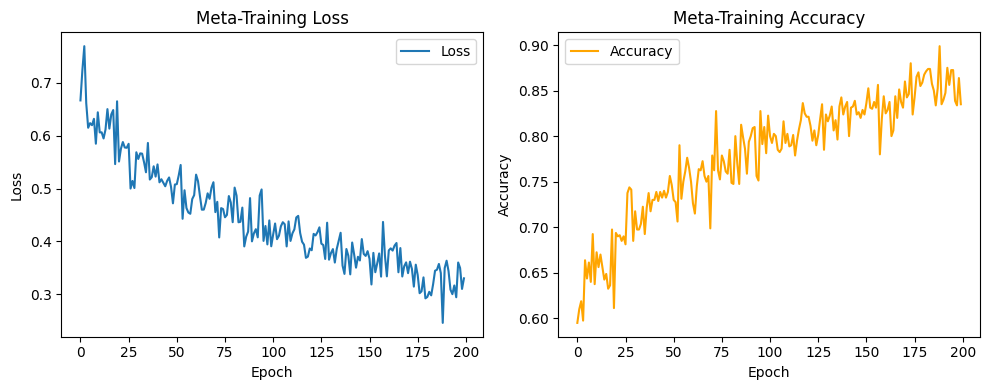

Outer Epoch 200: Loss = 0.3300, Acc = 0.8350
Final Loss: 0.3300
Final Accuracy: 83.50%
Test Set Evaluation over 100 tasks
Average Loss: 0.4106
Average Accuracy: 80.00%


In [ ]:
def main(device=torch.device('cuda')):
    global model,p,e
    p=TuningParameters()
    e=EpisodeSampler(p.train_ways,p.train_samples,p.test_samples)

    train_classes=p.train_ways
    train_samples=p.train_samples
    test_samples=p.test_samples
    epoch=p.epoch
    tasks_per_epoch=p.tasks_per_epoch
    
    
    model=BackBone_CNN(p.output_size).to(device)
    optimizer = optim.Adam(model.parameters(),lr=0.002)

    losses = []
    accuracies = []
    epochs = []

    for i in range(epoch):
        summed_loss,total_accuracy=0.0,0.0

        for j in range(tasks_per_epoch):

            #Episodes from training data are extracted and shifted to the GPU(or cpu)
            sdata,slabels,qdata,qlabels = e.sample_train_episode()
            support_data=sdata.to(device)           
            query_data=qdata.to(device)
            support_labels=slabels.to(device)
            query_labels=qlabels.to(device)

            #embedding the support/query data using CNN(backbone) and call the MetaIO_params class
            support_embeddings=model(support_data)
            query_embeddings=model(query_data)
            m=MetaIO_params(support_embeddings,support_labels,query_embeddings,query_labels)

            ce_loss,accuracy=m.get_params()
            summed_loss+=ce_loss
            total_accuracy+=accuracy.item()
            print(f"Inner: Epoch: {j}")
            
        optimizer.zero_grad()
        summed_loss.backward()
        optimizer.step()
        
        
        # Averaged metrics
        avg_loss=summed_loss.item()/tasks_per_epoch
        avg_acc=total_accuracy/tasks_per_epoch
        losses.append(avg_loss)
        accuracies.append(avg_acc)
        epochs.append(i)

        #Accuracy and Loss / Epoch plots 
        clear_output(wait=True)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(epochs,losses,label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Meta-Training Loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(epochs,accuracies,label='Accuracy',color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Meta-Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

        if i:
            print(f"Outer Epoch {i+1}: Loss={avg_loss:.4f}, Acc={avg_acc:.4f}")
        torch.cuda.empty_cache()
        gc.collect()              
    print(f"Final Loss: {losses[-1]:.4f}")
    print(f"Final Accuracy: {accuracies[-1] * 100:.2f}%")
    evaluate_on_test_set(model, e, p, device=torch.device('cuda'), num_tasks=100)

if __name__=="__main__":
    main()
    #garbage_disposal()                #Use it if you run trials and need the memory to be cleared.
    

In [ ]:
#Garbage collection fn
'''Forcefully releases GPU memory and triggers garbage collection to clean up residual objects after training.'''

def garbage_disposal():
    import gc
    import torch
    print("\n[INFO] Cleaning up memory...")

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        print("[INFO] Cleared CUDA memory.")

    # Clear CPU-side objects
    gc.collect()
    print("[INFO] Garbage collection complete.")